In [15]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [16]:
training_file_path = "/content/Training.csv"
test_file_path = "/content/Testing.csv"
train_df = pd.read_csv(training_file_path)
train_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [17]:
train_df["prognosis"].value_counts()

prognosis
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic hemmorhoids(piles)               120
Heart attack                               120
Varicose veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary tract infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B                                120
All

In [18]:
missing_vals = train_df.isna().sum()
missing_vals[missing_vals.gt(0)]

Unnamed: 133    4920
dtype: int64

In [19]:
train_df['Unnamed: 133'].value_counts(dropna=False)

Unnamed: 133
NaN    4920
Name: count, dtype: int64

In [20]:
train_df = train_df.drop('Unnamed: 133', axis=1)

In [21]:
label_encoder = preprocessing.LabelEncoder()

train_df["prognosis"] = label_encoder.fit_transform(train_df['prognosis'])
train_df["prognosis"].head()

0    15
1    15
2    15
3    15
4    15
Name: prognosis, dtype: int64

In [22]:
label_encoder.classes_

array(['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne',
       'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma',
       'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis',
       'Common Cold', 'Dengue', 'Diabetes ',
       'Dimorphic hemmorhoids(piles)', 'Drug Reaction',
       'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia',
       'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine',
       'Osteoarthristis', 'Paralysis (brain hemorrhage)',
       'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis',
       'Typhoid', 'Urinary tract infection', 'Varicose veins',
       'hepatitis A'], dtype=object)

In [23]:
train_df.dtypes.unique()

array([dtype('int64')], dtype=object)

In [24]:
X = train_df.copy()
y = X.pop('prognosis') # this removes the prognosis columns from X and assigns into y

X = torch.tensor(X.values).double()
y = torch.tensor(y).long() # CrossEntropyLoss expects classification predictions to be long

X, y

(tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 1., 1.]], dtype=torch.float64),
 tensor([15, 15, 15,  ..., 38, 35, 27]))

In [25]:
X.shape, y.shape

(torch.Size([4920, 132]), torch.Size([4920]))

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

(torch.Size([3936, 132]),
 torch.Size([984, 132]),
 torch.Size([3936]),
 torch.Size([984]))

In [27]:
bs = 32

train_dataset = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_dataset, bs, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_dl = DataLoader(val_dataset, bs, shuffle=True)

In [28]:
n_classes = len(label_encoder.classes_)
n_classes

41

In [29]:
model = nn.Sequential(
    nn.Linear(132, n_classes).double(),
    nn.Softmax(dim=-1)
)
model

Sequential(
  (0): Linear(in_features=132, out_features=41, bias=True)
  (1): Softmax(dim=-1)
)

In [30]:
# create loss function
loss_fn = nn.CrossEntropyLoss()

# create optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [32]:
def train_one_epoch():
    model.train()

    train_loss = 0.0

    for features, targets in train_dl:
        optimizer.zero_grad()                 # 1. Set the gradients to zero
        preds = model(features)               # 2. forward pass
        loss = loss_fn(preds, targets)        # 3. compute loss
        loss.backward()                       # 4. Compute the gradients
        optimizer.step()                      # 5. Update the model's parameters
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_dl)
    return avg_train_loss


def validate_with_accuracy():
    model.eval()  # set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # no need to compute gradients during validation
        for X, y in val_dl:
            preds = model(X)
            loss = loss_fn(preds, y)
            val_loss += loss.item()

            _, predicted = torch.max(preds, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    avg_val_loss = val_loss / len(val_dl)
    accuracy = correct / total
    return avg_val_loss, accuracy


def train_model(num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []  # List to store validation accuracies

    for epoch in range(num_epochs):
        # Train for one epoch and store the training loss
        train_loss = train_one_epoch()
        train_losses.append(train_loss)

        # Validate the model and store the validation loss
        avg_val_loss, val_accuracy = validate_with_accuracy()
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if ((epoch + 1) % 10) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, val_accuracies

In [33]:
def plot_losses_and_accuracy(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(14, 10))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 10))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.title('Validation Accuracies')
    plt.legend()
    plt.show()

Epoch 10/700, Train Loss: 3.7111, Validation Loss: 3.7110, Validation Accuracy: 0.1545
Epoch 20/700, Train Loss: 3.7079, Validation Loss: 3.7079, Validation Accuracy: 0.3100
Epoch 30/700, Train Loss: 3.7034, Validation Loss: 3.7035, Validation Accuracy: 0.4065
Epoch 40/700, Train Loss: 3.6964, Validation Loss: 3.6965, Validation Accuracy: 0.5010
Epoch 50/700, Train Loss: 3.6820, Validation Loss: 3.6824, Validation Accuracy: 0.4593
Epoch 60/700, Train Loss: 3.6438, Validation Loss: 3.6467, Validation Accuracy: 0.3577
Epoch 70/700, Train Loss: 3.5925, Validation Loss: 3.5981, Validation Accuracy: 0.3648
Epoch 80/700, Train Loss: 3.5486, Validation Loss: 3.5534, Validation Accuracy: 0.3618
Epoch 90/700, Train Loss: 3.5245, Validation Loss: 3.5308, Validation Accuracy: 0.4339
Epoch 100/700, Train Loss: 3.5070, Validation Loss: 3.5131, Validation Accuracy: 0.5010
Epoch 110/700, Train Loss: 3.4808, Validation Loss: 3.4879, Validation Accuracy: 0.5742
Epoch 120/700, Train Loss: 3.4394, Valida

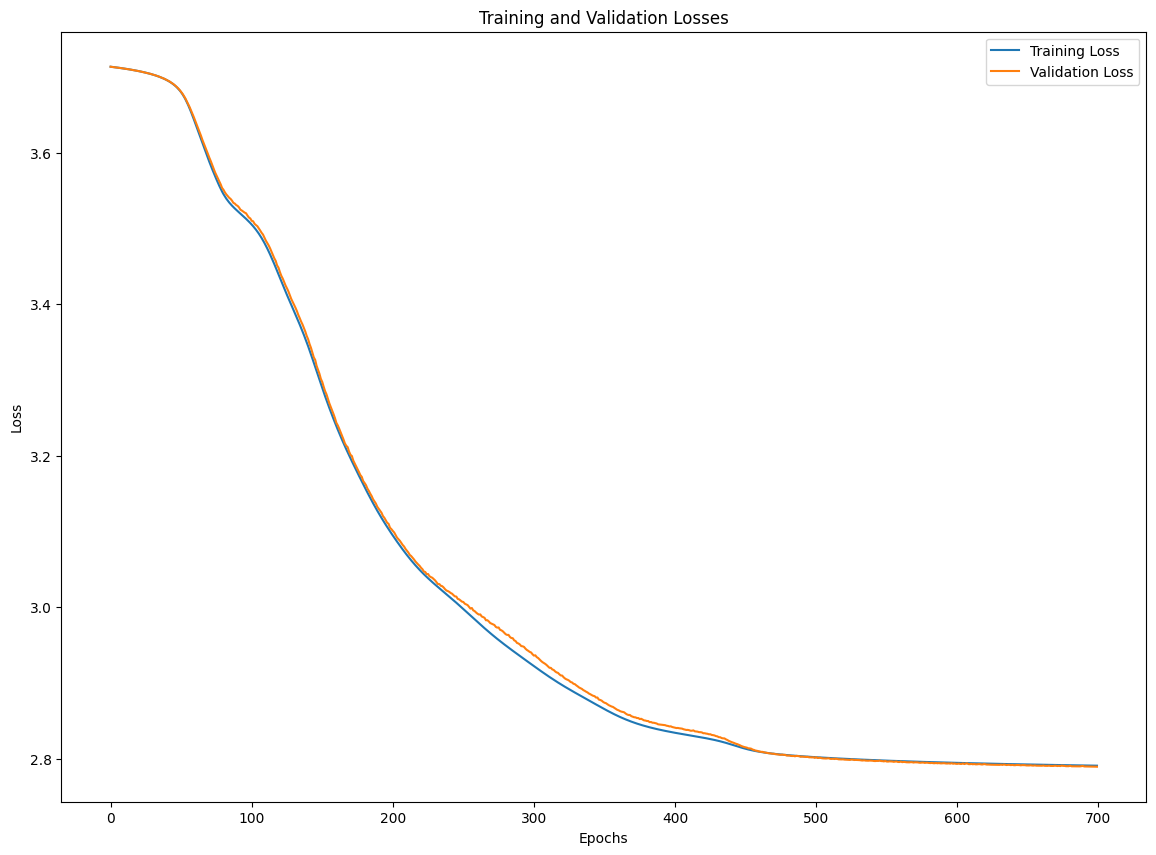

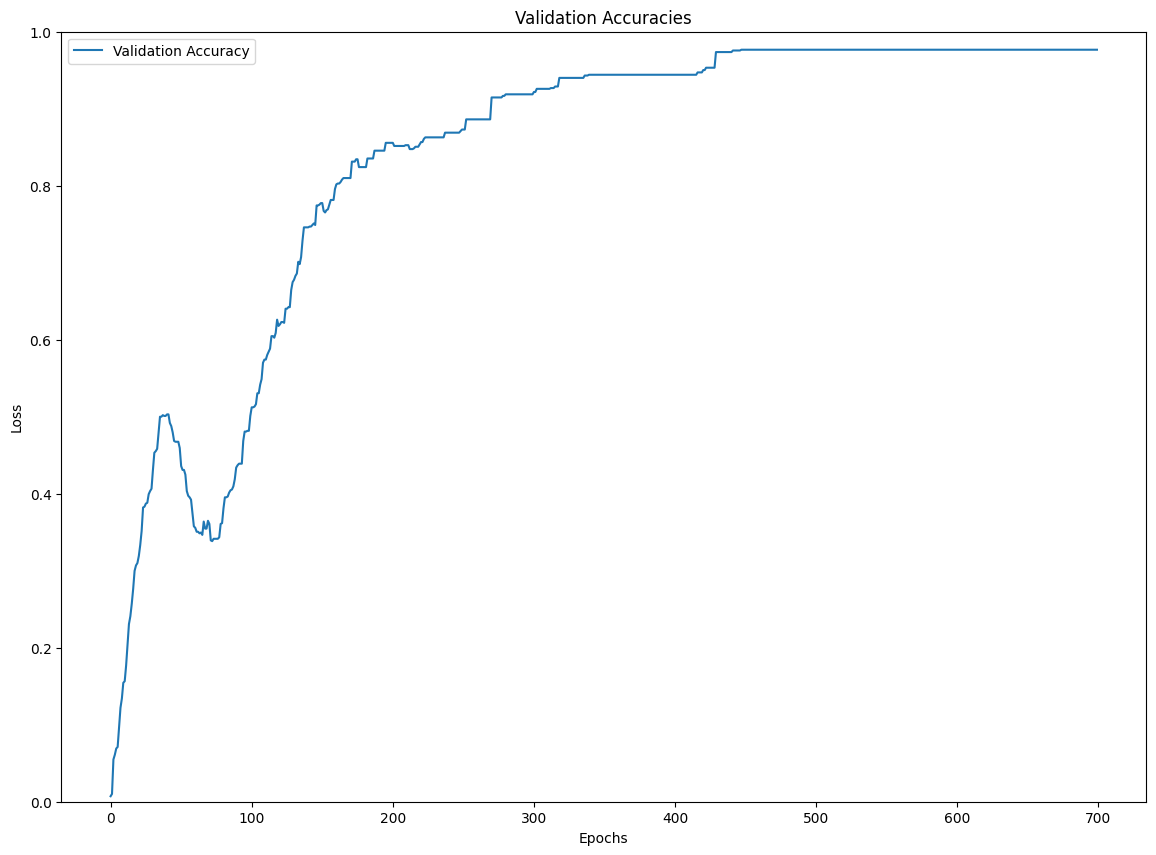

In [34]:
num_epochs = 700
train_losses, val_losses, val_accuracies = train_model(num_epochs)
plot_losses_and_accuracy(train_losses, val_losses, val_accuracies)

In [35]:
test_df = pd.read_csv(test_file_path)
test_df.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Drug Reaction


In [36]:
test_df["prognosis"] = label_encoder.transform(test_df['prognosis'])
test_df["prognosis"].head()

0    15
1     4
2    16
3     9
4    14
Name: prognosis, dtype: int64

In [37]:
X_test = train_df.copy()
y_test = X_test.pop('prognosis')

X_test = torch.tensor(X_test.values).double()
y_test = torch.tensor(y_test).long()

X_test, y_test

(tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 1., 1.]], dtype=torch.float64),
 tensor([15, 15, 15,  ..., 38, 35, 27]))

In [38]:
X_test.shape, y_test.shape

(torch.Size([4920, 132]), torch.Size([4920]))

In [39]:
test_dataset = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_dataset, bs, shuffle=True)

In [40]:
def test_accuracy_and_stats(label_encoder):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_true = []
    with torch.no_grad():
        for X, y in test_dl:
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(y.cpu().numpy())

    # Compute overall accuracy
    overall_accuracy = accuracy_score(all_true, all_preds)

    # Initialize counters for each class
    class_counts = {label: 0 for label in label_encoder.classes_}
    correct_counts = {label: 0 for label in label_encoder.classes_}

    # Count correct predictions and total instances for each class
    for true, pred in zip(all_true, all_preds):
        true_label = label_encoder.inverse_transform([true])[0]
        pred_label = label_encoder.inverse_transform([pred])[0]
        class_counts[true_label] += 1
        if true == pred:
            correct_counts[true_label] += 1

    # Prepare data for DataFrame
    data = []
    for label in label_encoder.classes_:
        accuracy = correct_counts[label] / class_counts[label] if class_counts[label] > 0 else 0
        data.append({
            'Class': label,
            'Total Predictions': class_counts[label],
            'Correct Predictions': correct_counts[label],
            'Accuracy': accuracy
        })

    # Convert data to DataFrame
    df_stats = pd.DataFrame(data)

    return overall_accuracy, df_stats

In [41]:
overall_accuracy, df_stats = test_accuracy_and_stats(label_encoder)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")
df_stats

Overall Test Accuracy: 0.9756


,Class,Total Predictions,Correct Predictions,Accuracy
0,(vertigo) Paroymsal Positional Vertigo,120,120,1.0
1,AIDS,120,120,1.0
2,Acne,120,120,1.0
3,Alcoholic hepatitis,120,120,1.0
4,Allergy,120,120,1.0
5,Arthritis,120,120,1.0
6,Bronchial Asthma,120,120,1.0
7,Cervical spondylosis,120,120,1.0
8,Chicken pox,120,120,1.0
9,Chronic cholestasis,120,120,1.0
